# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [4]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [6]:
try: 
    snakemake.input.tree 
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [7]:
try:
    path = snakemake.input.alignment
    dropped_strains = [line.rstrip('\n') for line in open(snakemake.input.dropped_strains,"r")]
    tree_path = snakemake.input.tree
    if snakemake.input.clade_names is not None:
        clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
    f = open(snakemake.input.disease_name, "r")
    virus_name = f.read()
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


### Old Flu Files

In [66]:
#path = "../seasonal-flu-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = []
#tree_path = "../auspice/flu_seasonal_h3n2_ha_2y.json"
virus_name = "Flu"
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

# Reading in all the data from the scripts

In [75]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/seasonal-flu-nextstrain'

In [76]:
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [77]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [78]:
similarity_matrix = pd.read_csv("results/distance_matrix.csv", index_col=0)

In [79]:
similarity_matrix.columns = similarity_matrix.index

In [80]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/seasonal-flu-nextstrain'

In [73]:
node_df.head()

strain     date  pca1  pca2   mds1  mds2  tsne_x  tsne_y  \
0  A/MUWRP-Uganda/579/2016  2016.67 -1.09  5.47  10.94 -7.15   20.11    6.91   
1       A/Shiraz/1011/2015  2015.89 -1.38  5.41   8.83 -5.65   19.87    5.90   
2       A/Shiraz/1019/2016  2016.00 -1.53  5.40   7.01  9.17   19.89    5.97   
3       A/Shiraz/1020/2016  2016.02 -1.53  5.39   5.57  6.02   19.90    6.01   
4      A/Chungbuk/107/2016  2016.05 -1.49  5.12   1.67  0.33   20.34    7.23   

   umap_x  umap_y clade_membership  y  
0   17.77   -1.75              3c3  1  
1   17.92   -1.28            3c3.B  2  
2   17.79   -1.15              3c3  3  
3   18.03   -1.14              3c3  4  
4   10.55    5.35              3c3  5

In [74]:
node_df.shape

(1149, 12)

In [15]:
node_df.head()

strain     date  pca1  pca2   mds1   mds2  tsne_x  tsne_y  \
0       A/Shiraz/1005/2015  2015.78 -1.20  3.03   5.68  -5.20  -13.70  -14.70   
1  A/RobatKarim/21210/2016  2016.05 -1.53  4.35  -4.52  -7.25   -5.95  -46.27   
2      A/Chungbuk/107/2016  2016.05 -1.56  5.09   1.95 -10.69   -6.62  -46.63   
3  A/MUWRP-Uganda/579/2016  2016.67 -1.18  5.45 -15.09 -24.65   -7.04  -46.56   
4       A/Shiraz/1011/2015  2015.89 -1.46  5.39   1.45  -0.85   -7.59  -45.60   

   umap_x  umap_y clade_membership  y  
0    5.26    8.35              3c2  1  
1    5.61    8.61              3c2  2  
2    5.30    8.83              3c3  3  
3    3.95   18.42              3c3  4  
4    3.84   18.24            3c3.B  5

In [89]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

In [17]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

A/Brisbane/280/2016  A/Brisbane/302/2016  \
A/Brisbane/280/2016                        0                    2   
A/Brisbane/302/2016                        2                    0   
A/California/122/2016                      6                    4   
A/NewYork/57/2016                          5                    3   
A/Texas/178/2016                           6                    4   
...                                      ...                  ...   
A/Kenya/013/2017                          61                   59   
A/India/1736032/2017                      57                   55   
A/HongKong/3391/2017                      41                   39   
A/India/1732610/2017                      67                   65   
A/MUWRP-Uganda/579/2016                   35                   33   

                         A/California/122/2016  A/NewYork/57/2016  \
A/Brisbane/280/2016                          6                  5   
A/Brisbane/302/2016                          4                  3   
A/California/122/2016                        0                  3   
A/NewYork/57/2016                            3                  0   
A/Texas/178/2016                             6                  3   
...                                        ...                ...   
A/Kenya/013/2017                            59                 56   
A/India/1736032/2017                        55                 52   
A/HongKong/3391/2017                        39                 38   
A/India/1732610/2017                        65                 62   
A/MUWRP-Uganda/579/2016                     33                 32   

                         A/Texas/178/2016  A/Perth/22/2016  A/Sydney/142/2016  \
A/Brisbane/280/2016                     6                7                  6   
A/Brisbane/302/2016                     4                5                  4   
A/California/122/2016                   6                5                  8   
A/NewYork/57/2016                       3                4                  5   
A/Texas/178/2016                        0                7                  6   
...                                   ...              ...                ...   
A/Kenya/013/2017                       59               60                 61   
A/India/1736032/2017                   55               56                 57   
A/HongKong/3391/2017                   41               38                 43   
A/India/1732610/2017                   65               66                 66   
A/MUWRP-Uganda/579/2016                35               32                 37   

                         A/Brisbane/291/2016  A/Townsville/51/2016  \
A/Brisbane/280/2016                        6                     9   
A/Brisbane/302/2016                        4                     7   
A/California/122/2016                      8                    11   
A/NewYork/57/2016                          5                     8   
A/Texas/178/2016                           6                     9   
...                                      ...                   ...   
A/Kenya/013/2017                          61                    64   
A/India/1736032/2017                      57                    58   
A/HongKong/3391/2017                      43                    46   
A/India/1732610/2017                      67                    68   
A/MUWRP-Uganda/579/2016                   36                    39   

                         A/Idaho/33/2016  ...  A/Thailand/CU-B21722/2017  \
A/Brisbane/280/2016                    8  ...                         38   
A/Brisbane/302/2016                    6  ...                         37   
A/California/122/2016                  6  ...                         37   
A/NewYork/57/2016                      5  ...                         36   
A/Texas/178/2016                       8  ...                         39   
...                                  ...  ...                        ...   
A/Kenya/013/2017     

In [18]:
node_df

strain     date  pca1  pca2   mds1   mds2  tsne_x  \
0          A/Shiraz/1005/2015  2015.78 -1.20  3.03   5.68  -5.20  -13.70   
1     A/RobatKarim/21210/2016  2016.05 -1.53  4.35  -4.52  -7.25   -5.95   
2         A/Chungbuk/107/2016  2016.05 -1.56  5.09   1.95 -10.69   -6.62   
3     A/MUWRP-Uganda/579/2016  2016.67 -1.18  5.45 -15.09 -24.65   -7.04   
4          A/Shiraz/1011/2015  2015.89 -1.46  5.39   1.45  -0.85   -7.59   
...                       ...      ...   ...   ...    ...    ...     ...   
1145        A/Italy/6950/2018  2018.09 -3.01 -0.98   2.59  -3.92   38.83   
1146        A/Italy/7368/2018  2018.21 -3.01 -0.98   1.91  -3.77   39.11   
1147      A/Germany/7025/2018  2018.03 -3.00 -1.00   1.83  -3.88   39.59   
1148      A/Minnesota/27/2018  2018.24 -3.00 -0.98   2.22  -3.95   39.59   
1149         A/Guam/7145/2018  2018.12 -3.00 -0.98   1.97  -3.77   39.59   

      tsne_y  umap_x  umap_y clade_membership     y clade_membership_color  
0     -14.70    5.26    8.35              3c2     1                    3c2  
1     -46.27    5.61    8.61              3c2     2                    3c2  
2     -46.63    5.30    8.83              3c3     3                    3c3  
3     -46.56    3.95   18.42              3c3     4                    3c3  
4     -45.60    3.84   18.24            3c3.B     5                  3c3.B  
...      ...     ...     ...              ...   ...                    ...  
1145  -20.76   -3.51    1.77         A1b/135K  1146               A1b/135K  
1146  -20.83   -3.11    2.50         A1b/135K  1147               A1b/135K  
1147  -20.95   -3.02    2.44         A1b/135K  1148               A1b/135K  
1148  -20.95   -3.07    2.34         A1b/135K  1149               A1b/135K  
1149  -20.95   -3.39    2.50         A1b/135K  1150               A1b/135K  

[1150 rows x 13 columns]

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [81]:
#principalDf = pd.read_csv(snakemake.input.pca)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [84]:
#explained_variance_df = pd.read_csv(snakemake.input.pca + "explained_variance")
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.2718                     0
1              0.1594                     1
2              0.0900                     2
3              0.0582                     3
4              0.0268                     4
5              0.0220                     5
6              0.0209                     6
7              0.0185                     7
8              0.0146                     8
9              0.0106                     9

In [85]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

alt.Chart(...)

In [90]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [91]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4      pca5  \
0   A/Alabama/14/2017 -1.647656 -1.451646  0.540854 -0.946095 -0.963831   
1    A/Sydney/25/2017 -1.654396 -1.465453  0.522655 -0.993204 -1.005841   
2  A/Maryland/33/2017 -1.647283 -1.455063  0.512042 -0.974183 -0.963926   
3   A/Arizona/35/2017 -1.870699 -1.622564  0.345735 -0.569097 -1.536677   
4  A/Maryland/10/2017 -1.847439 -1.626363  0.284899 -0.653105 -1.575416   

       pca6      pca7      pca8      pca9     pca10  pca_label     date    y  \
0 -0.479055  0.138428 -0.241234 -0.315891  0.035317         13  2017.20  781   
1 -0.441615  0.121431 -0.227059 -0.327008  0.021550         13  2017.11  777   
2 -0.440028  0.129124 -0.189153 -0.324841 -0.018416         13  2017.29  779   
3  0.851519  0.390365 -0.134110 -0.432367 -0.707311          7  2017.38  783   
4  0.951081  0.398280 -0.044482 -0.373755 -0.891917          7  2017.08  790   

  clade_membership clade_membership_color  
0               A1                  other  
1               A1                  other  
2               A1                  other  
3               A1                  other  
4               A1                  other

In [92]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [93]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [94]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

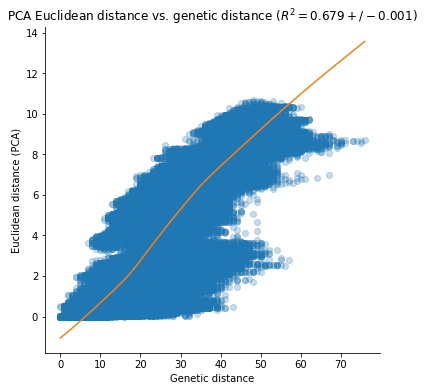

In [95]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_PCA = pd.read_csv("results/scatterplot_pca.csv",index_col=0)
metadata_PCA = pd.read_csv("results/scatterplot_pca_metadata.csv", index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

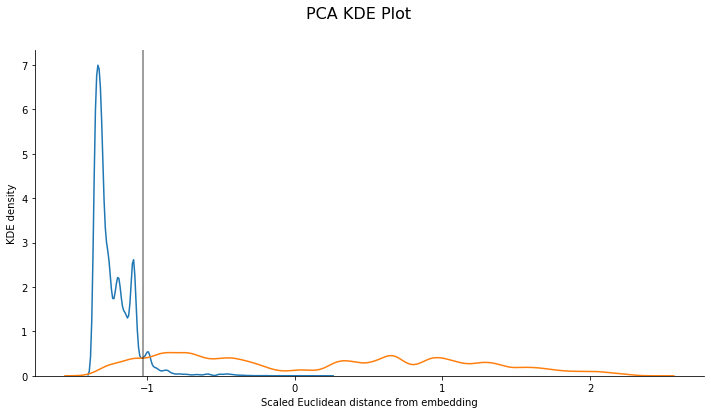

In [96]:
PCA_KDE_df = pd.read_csv("results/KDEDensity_pca.csv",index_col=0)
PCA_KDE_metadata_df = pd.read_csv("results/KDEDensity_pca_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [97]:
#principalDf = pd.read_csv(snakemake.input.pca)
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)

In [98]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [99]:
merged_mds_df

strain       mds1       mds2       mds3       mds4  \
0           A/Alabama/14/2017   2.182183   4.053976  -7.230840  -6.110226   
1            A/Sydney/25/2017   1.695638   3.593238  -7.361811  -6.329109   
2          A/Maryland/33/2017   3.871731   5.923091  -8.259581  -8.105452   
3           A/Arizona/35/2017   1.278545   6.825168  -8.726467 -10.089251   
4          A/Maryland/10/2017   0.280989   5.744651  -7.931216  -7.506116   
...                       ...        ...        ...        ...        ...   
1144     A/India/1733873/2017  -2.352563   6.812282 -14.871108   1.899980   
1145     A/India/1736032/2017   0.356339  12.107540 -14.010568  -0.004021   
1146     A/HongKong/3391/2017  -2.518165  -1.440444  13.599539 -11.177177   
1147         A/Kenya/013/2017   9.061478   4.330886 -15.006084  -0.000531   
1148  A/MUWRP-Uganda/579/2016  10.938328  -7.146971   9.065623   6.876507   

           mds5       mds6      mds7       mds8       mds9     mds10  \
0     -1.181367  -0.480923  2.587089  -2.435035   1.911261  7.406473   
1      0.429091   0.849587  1.050646  -4.426933   1.236404  7.126725   
2      1.582560   1.164888  3.895365  -4.152353   1.363661  6.809950   
3      0.717537   0.111655  4.171037  -2.262053   4.138805  9.155975   
4      1.148469   0.394092  1.458931  -2.188318   2.866919  6.765682   
...         ...        ...       ...        ...        ...       ...   
1144   5.470040 -17.793847  0.264409   7.055923   7.818917  6.549383   
1145  11.419619 -14.326845 -6.080406   1.577887   7.548486  1.108992   
1146  -8.356206  -6.460711 -2.232558   8.797618  -6.397000 -2.871345   
1147  10.619435 -20.906869 -4.894140 -10.424091   2.020001  0.373300   
1148  -5.322772  -1.762432  7.536488  26.667635 -22.798539 -1.584239   

      mds_label     date     y clade_membership clade_membership_color  
0             7  2017.20   781               A1                  other  
1            -1  2017.11   777               A1                  other  
2            -1  2017.29   779               A1                  other  
3            -1  2017.38   783               A1                  other  
4            -1  2017.08   790               A1                  other  
...         ...      ...   ...              ...                    ...  
1144         -1  2017.71  1104         A1b/135N               A1b/135N  
1145         -1  2017.79  1101         A1b/135N               A1b/135N  
1146         -1  2017.52   229               A3                     A3  
1147         -1  2017.19   990              A1b                  other  
1148         -1  2016.67     1              3c3                  other  

[1149 rows x 16 columns]

In [100]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership:N')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [101]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [102]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

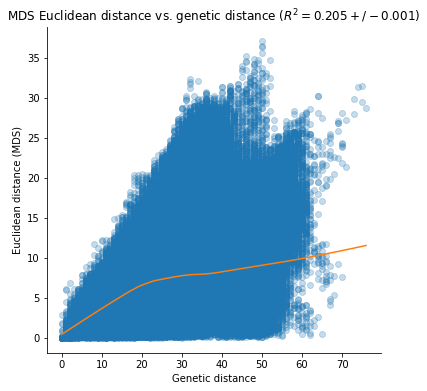

In [103]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_MDS = pd.read_csv("results/scatterplot_mds.csv",index_col=0)
metadata_MDS = pd.read_csv("results/scatterplot_mds_metadata.csv", index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

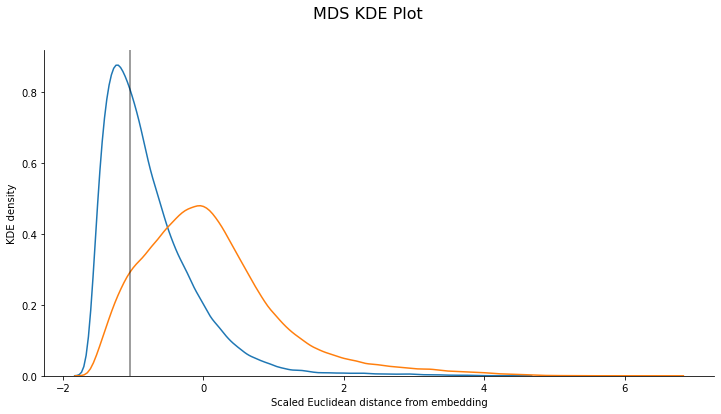

In [104]:
MDS_KDE_df = pd.read_csv("results/KDEDensity_mds.csv",index_col=0)
MDS_KDE_metadata_df = pd.read_csv("results/KDEDensity_mds_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [105]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = pd.read_csv("results/embed_t-sne.csv",index_col=0)

In [106]:
TSNE_df

tsne_x     tsne_y  t-sne_label
strain                                                    
A/Alabama/14/2017       -39.715492  13.019563           18
A/Sydney/25/2017        -39.443610  13.680430           18
A/Maryland/33/2017      -39.756405  12.559565           18
A/Arizona/35/2017       -41.567463  15.235610           18
A/Maryland/10/2017      -41.150517  15.037233           18
...                            ...        ...          ...
A/India/1736032/2017      4.245200  47.066547           15
A/HongKong/3391/2017    -28.074087 -31.277283           -1
A/Kenya/013/2017         -0.699793  33.356230            1
A/India/1732610/2017      4.425462  46.078827           15
A/MUWRP-Uganda/579/2016  20.110592   6.910751            3

[1150 rows x 3 columns]

In [107]:
merged_tsne_df = TSNE_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [108]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [109]:
list_of_chart = linking_tree_with_plots_clickable(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ['t-sne_label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

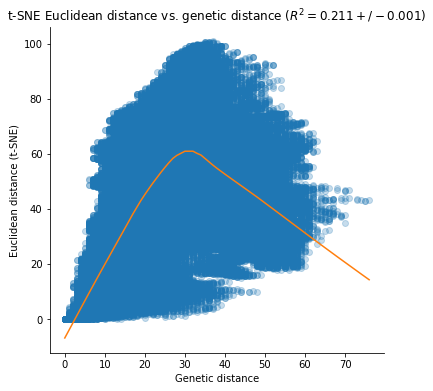

In [110]:
total_df_TSNE = pd.read_csv("results/scatterplot_t-sne.csv",index_col=0)
metadata_TSNE = pd.read_csv("results/scatterplot_t-sne_metadata.csv", index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")

ax.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

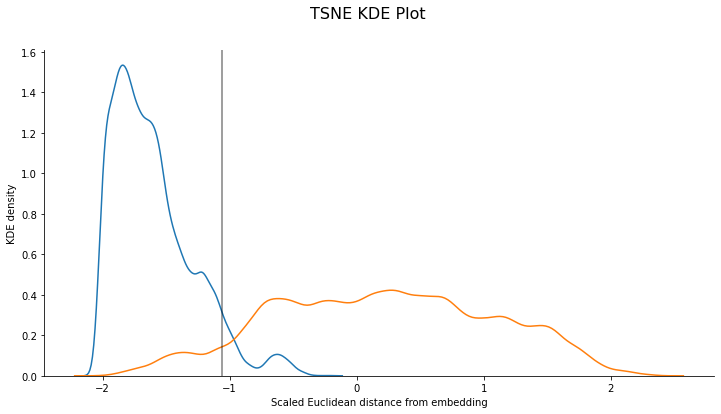

In [111]:
TSNE_KDE_df = pd.read_csv("results/KDEDensity_t-sne.csv",index_col=0)
TSNE_KDE_metadata_df = pd.read_csv("results/KDEDensity_t-sne_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [112]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("results/embed_umap.csv",index_col=0)

In [113]:
merged_umap_df = UMAP_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [114]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

# HDBSCAN Output

In [115]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'umap_label:N',
    ['umap_label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

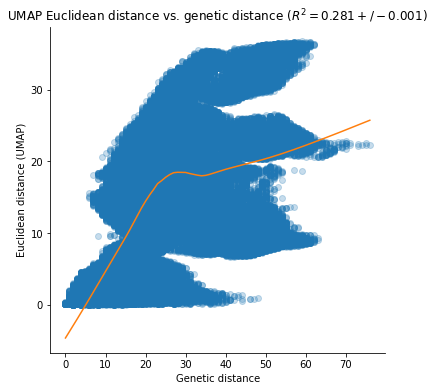

In [116]:
total_df_UMAP = pd.read_csv("results/scatterplot_umap.csv",index_col=0)
metadata_UMAP = pd.read_csv("results/scatterplot_umap_metadata.csv", index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")

ax.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")
sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

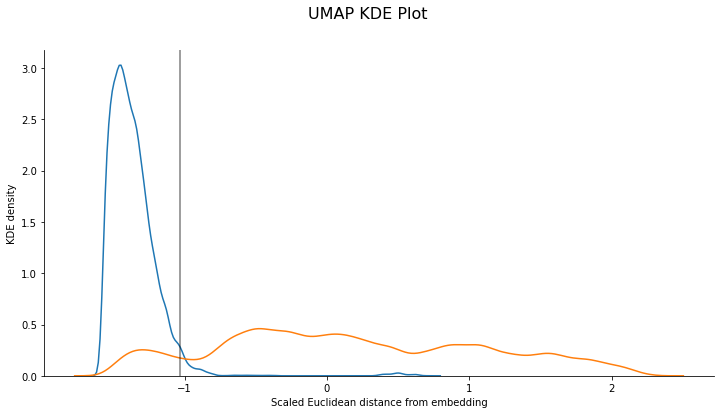

In [117]:
UMAP_KDE_df = pd.read_csv("results/KDEDensity_umap.csv",index_col=0)
UMAP_KDE_metadata_df = pd.read_csv("results/KDEDensity_umap_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [121]:
merged_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]].merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [122]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [123]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save("results/FullLinkedChartClickable" + "Zika" + ".html")
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

In [124]:
fullChart

alt.HConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

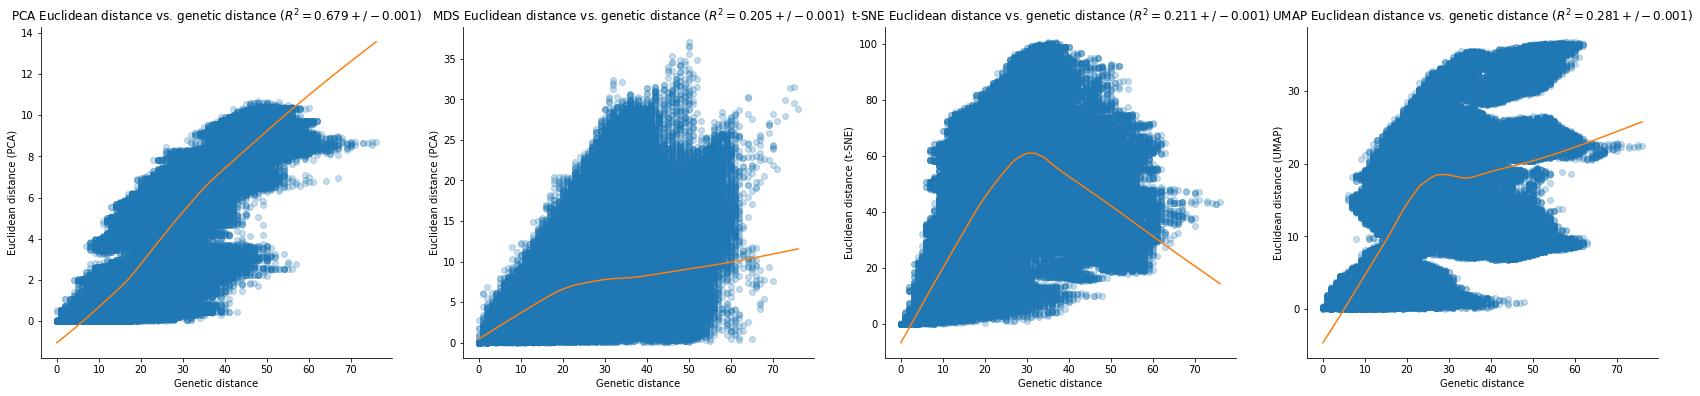

In [126]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig("../docs/FullScatterplot" + "Flu" + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [127]:
Genetic_KDE_df = pd.read_csv("results/KDEDensity_genetic.csv",index_col=0)
Genetic_KDE_metadata_df = pd.read_csv("results/KDEDensity_genetic_metadata.csv", index_col=0)

In [128]:
import matplotlib.gridspec as gridspec

In [ ]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(24, 12), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[1, 3])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FullKDEDensity" + "Flu" + ".png")

# Supplemental Figures

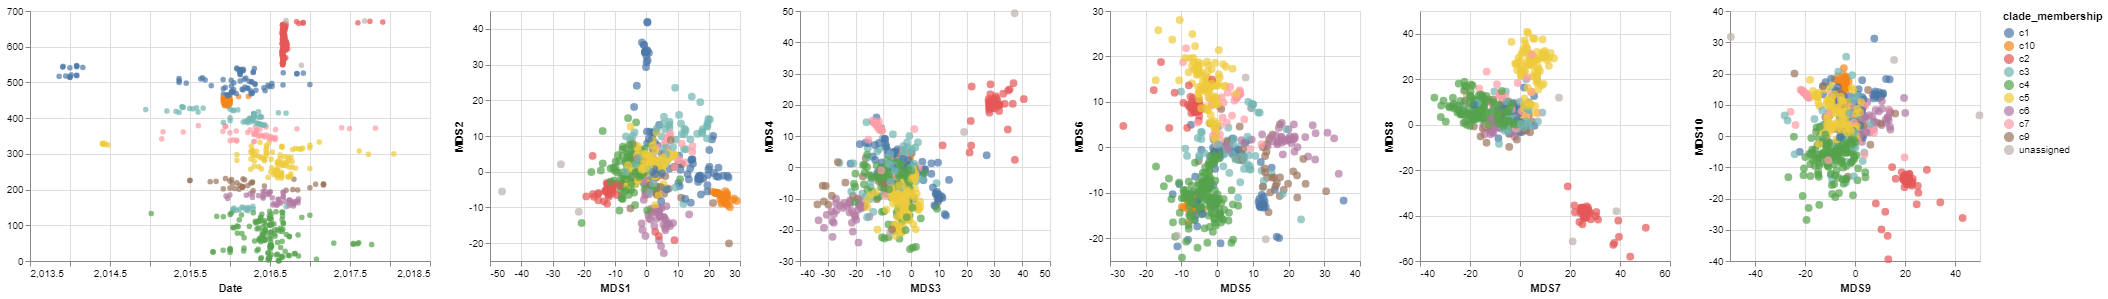

In [116]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

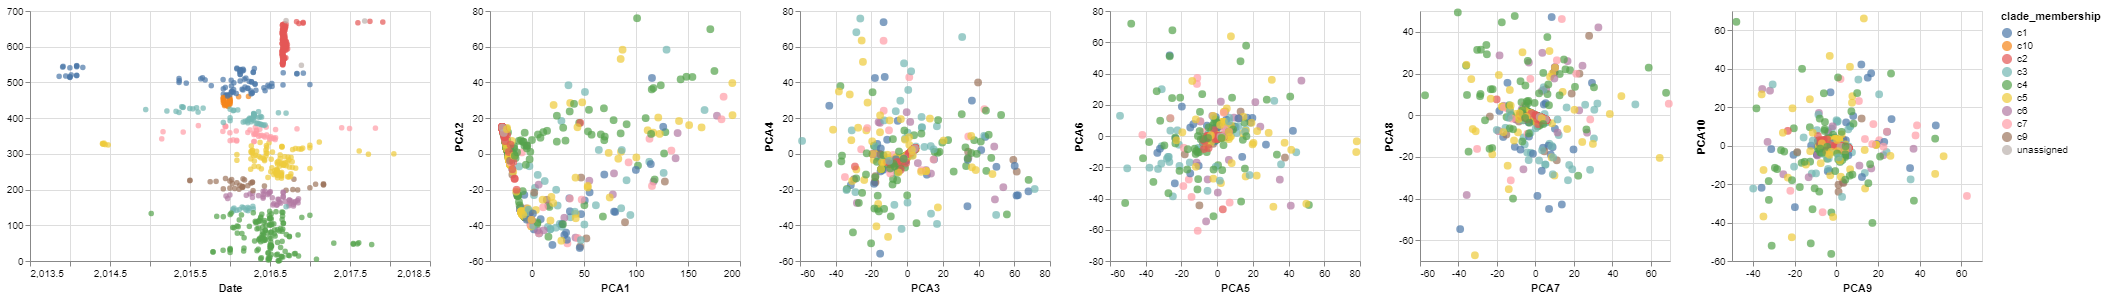

In [117]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]